In [2]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
import keras
import pickle
import tensorflow as tf
import tensorflow.keras

In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

# Loading and formatting the data
---

In [2]:
# Setting cute at index 1.  This will slightly simplify the final rating process
# since we can just average out the values.
CATEGORIES = ["subset-ugly", "subset-cute"]
DIRECTORY = "./Data/Images"

In [39]:
def transform_image(img):
    """
    Adds black padding around an image to make it square,
    then resizes to 96x96, then returns.
    """
    
    # I don't want to stretch the image, so I'll add padding to make it
    # square based on the largest dimension.
    dims = img.shape[:2]
    argmax_dim = np.argmax(dims)
    max_dim = dims[argmax_dim]

    # Shape is height, width, depth.  So, if argmax is 0 then height is max
    # and I should pad the left and right.  Opposite respectively for width.
    padding_amount = abs(np.diff(dims).item()) // 2

    padding_options = {
        0: {'top': 0, 'bottom': 0, 'left': padding_amount, 'right': padding_amount},
        1: {'top': padding_amount, 'bottom': padding_amount, 'left': 0, 'right': 0}
    }

    padding = padding_options[argmax_dim]

    # cv2.copyMakeBorder(src, top, bottom, left, right, method)
    padded = cv2.copyMakeBorder(img, **padding, borderType=cv2.BORDER_ISOLATED)

    resized = cv2.resize(padded, (96, 96))

    return resized

In [3]:
def create_dataset():
    dataset = []
    
    for category in CATEGORIES:
        path = os.path.join(DIRECTORY, category)

        # 0 is ugly, 1 is cute
        label = CATEGORIES.index(category)

        for filename in os.listdir(path):
            img = cv2.imread(os.path.join(path, filename))

            ### transformed = transform_image(img)
            # Trying out just resizing
            transformed = cv2.resize(img, (96, 96))
            
            dataset.append((transformed, label))
            
    return dataset

In [4]:
dataset = create_dataset()
len(dataset)

3962

In [5]:
# Shuffle the dataset
random.shuffle(dataset)

In [6]:
X = []
y = []

for data, label in dataset:
    X.append(data)
    y.append(label)
    
X = np.array(X).reshape(-1, 96, 96, 3) # 3 channels, rgb

In [7]:
import pickle

with open("sub-X.pickle", 'wb') as pickle_out:
    pickle.dump(X, pickle_out)

with open("sub-y.pickle", 'wb') as pickle_out:
    pickle.dump(y, pickle_out)

# Commence training
---

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization

In [6]:
with open("sub-X.pickle", 'rb') as pickle_in:
    X = pickle.load(pickle_in)
    
with open("sub-y.pickle", 'rb') as pickle_in:
    y = pickle.load(pickle_in)

In [7]:
X = X / 255

In [11]:
X.shape

(3962, 96, 96, 3)

Incredible help (and copy paste) from https://www.pyimagesearch.com/2018/04/16/keras-and-convolutional-neural-networks-cnns/.

In [137]:
model = Sequential()

chanDim = -1

# CONV => RELU => POOL
model.add(Conv2D(32, (3, 3), padding="same",
    input_shape=(96, 96, 3)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# sigmoid classifier
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(X, y, batch_size=256, validation_split=0.2, epochs=30)

Train on 3169 samples, validate on 793 samples
Epoch 1/30
3169/3169 [==============================] - 8s 3ms/step - loss: 1.0895 - acc: 0.5841 - val_loss: 1.1486 - val_acc: 0.6116
Epoch 2/30
3169/3169 [==============================] - 5s 2ms/step - loss: 0.8776 - acc: 0.6295 - val_loss: 1.1462 - val_acc: 0.6230
Epoch 3/30
3169/3169 [==============================] - 5s 2ms/step - loss: 0.7062 - acc: 0.6665 - val_loss: 0.7150 - val_acc: 0.6898
Epoch 4/30
3169/3169 [==============================] - 5s 2ms/step - loss: 0.5969 - acc: 0.7154 - val_loss: 0.6593 - val_acc: 0.6822
Epoch 5/30
3169/3169 [==============================] - 5s 1ms/step - loss: 0.5825 - acc: 0.7144 - val_loss: 0.6991 - val_acc: 0.6671
Epoch 6/30
3169/3169 [==============================] - 5s 2ms/step - loss: 0.5385 - acc: 0.7378 - val_loss: 0.5856 - val_acc: 0.7062
Epoch 7/30
3169/3169 [==============================] - 5s 1ms/step - loss: 0.4975 - acc: 0.7684 - val_loss: 0.7858 - val_acc: 0.6683
Epoch 8/30
3169

In [169]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 96, 96, 32)        896       
_________________________________________________________________
activation_45 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_46 (Activation)   (None, 32, 32, 64)        0         
__________

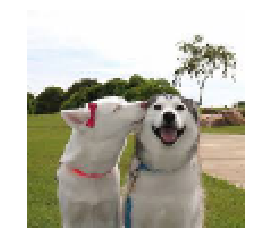

In [14]:
plt.axis("off")
plt.imshow(cv2.cvtColor(X[random.choice(range(2000))].astype(np.float32), cv2.COLOR_BGR2RGB))

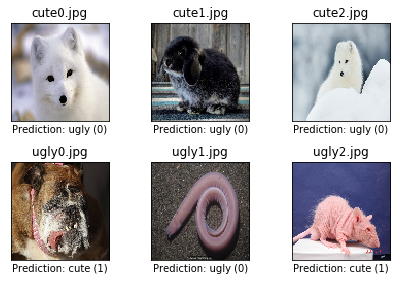

In [138]:
path = "./Test"

# plt.subplots(constrained_layout=True)
# subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

for i, filename in enumerate(os.listdir(path)):
    img = cv2.imread(os.path.join(path, filename))
    transformed = cv2.resize(img, (96, 96))
    
    to_predict = transformed.reshape(-1, 96, 96, 3)
    prediction = model.predict_classes(to_predict).item()
    pred_class = np.argmax(prediction)
    pred = "cute" if prediction else "ugly"
    
    ax = plt.subplot(2, 3, i+1)
    plt.title(filename)
    ax.set_xlabel("Prediction: {} ({})".format(pred, prediction))
    ax.set_xticks([])
    ax.set_yticks([])
#     plt.axis("off")
    plt.imshow(cv2.cvtColor(transformed, cv2.COLOR_BGR2RGB))
    
#     print("Name: {}\nPrediction: {}".format(filename, pred))

plt.tight_layout()

array([[0.]], dtype=float32)

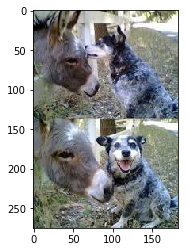

In [155]:
img = cv2.imread("./Data/Images/cute/{}.jpg".format(random.choice(range(1300, 2300))))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
transformed = cv2.resize(img, (96, 96))
to_predict = transformed.reshape(-1, 96, 96, 3)
model.predict(to_predict)

In [156]:
path = "./Data/Images/cute"
preds = []
for i, filename in enumerate(os.listdir(path)):
    if i > 300:
        break
    
    img = cv2.imread(os.path.join(path, filename))
    transformed = cv2.resize(img, (96, 96))
    to_predict = transformed.reshape(-1, 96, 96, 3)
    preds.append(model.predict(to_predict))
    
any(preds)

True

# Trying with pre-trained VGG16
---

In [8]:
from tensorflow.keras.models import model_from_json

In [6]:
# Load model structure from json
with open("model-structure.json", 'r') as structure_file:
    model_structure = structure_file.read()

loaded_model = model_from_json(model_structure)

In [7]:
len(loaded_model.layers)

29

In [16]:
# Load model weights from h5
loaded_model.load_weights("model-weights.hdf5")

ValueError: You are trying to load a weight file containing 17 layers into a model with 0 layers.

In [9]:
from tensorflow.keras.models import load_model

In [14]:
m = load_model("model-weights.hdf5")

ValueError: You are trying to load a weight file containing 17 layers into a model with 0 layers.

In [18]:
a = load_model("model.h5")

ValueError: You are trying to load a weight file containing 17 layers into a model with 0 layers.

In [10]:
from tensorflow.keras.models import model_from_yaml

In [22]:
# Load model structure from json
with open("model-structure.yaml", 'r') as structure_file:
    model_structure_yaml = structure_file.read()

m = model_from_yaml(model_structure_yaml)

In [23]:
m.load_weights("model-weights.hdf5")

ValueError: You are trying to load a weight file containing 17 layers into a model with 0 layers.

In [11]:
vgg16_model = tensorflow.keras.applications.vgg16.VGG16(include_top=False, input_shape=(96, 96, 3))

new_model = Sequential()

# We want to fine tune before flattening
for layer in vgg16_model.layers[:-4]:
    new_model.add(layer)
    
# Let's add a (CONV => RELU) * 2 => POOL
new_model.add(Conv2D(64, (3, 3), padding="same"))
new_model.add(Activation("relu"))
new_model.add(BatchNormalization(axis=-1))
new_model.add(Conv2D(64, (3, 3), padding="same"))
new_model.add(Activation("relu"))
new_model.add(BatchNormalization(axis=-1))
new_model.add(MaxPooling2D(pool_size=(2, 2)))
new_model.add(Dropout(0.25))

# And finally flatten, dense, and out
new_model.add(Flatten())
new_model.add(Dense(1024))
new_model.add(Activation("relu"))
new_model.add(BatchNormalization())
new_model.add(Dropout(0.5))

# sigmoid classifier
new_model.add(Dense(1))
new_model.add(Activation("sigmoid"))


# And we don't want to retrain anymore!
for layer in new_model.layers:
    layer.trainable = False


In [12]:
new_model.load_weights("model-weights.hdf5")

In [13]:
new_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [14]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 24, 24, 256)       295168    
__________

In [15]:
img = cv2.resize(cv2.imread("./Test/cute0.jpg"), (96, 96))
to_pred = img.reshape(-1, 96, 96, 3)

Thank goodness for this: https://stackoverflow.com/questions/38303974/tensorflow-running-error-with-cublas

In [17]:
new_model.predict(to_pred)

array([[1.]], dtype=float32)

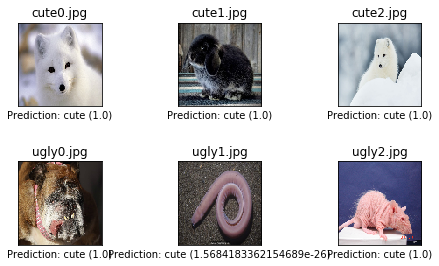

In [19]:
path = "./Test"

# plt.subplots(constrained_layout=True)
# subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

for i, filename in enumerate(os.listdir(path)):
    img = cv2.imread(os.path.join(path, filename))
    transformed = cv2.resize(img, (96, 96))
    
    to_predict = transformed.reshape(-1, 96, 96, 3)
    prediction = new_model.predict(to_predict).item()
    pred_class = np.argmax(prediction)
    pred = "cute" if prediction else "ugly"
    
    ax = plt.subplot(2, 3, i+1)
    plt.title(filename)
    ax.set_xlabel("Prediction: {} ({})".format(pred, prediction))
    ax.set_xticks([])
    ax.set_yticks([])
#     plt.axis("off")
    plt.imshow(cv2.cvtColor(transformed, cv2.COLOR_BGR2RGB))
    
#     print("Name: {}\nPrediction: {}".format(filename, pred))

plt.tight_layout()

**This is obviously not an exhaustive test!**